In [1]:
import os
import io
import random
import fnmatch
from csv import DictWriter
import pandas as pd

import pdb

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from deap import base, creator, tools
import math

The value from the attribute 'distance_matrix' : 8.06225774829855
The value from the attribute 'node_coordinates': 8.06225774829855


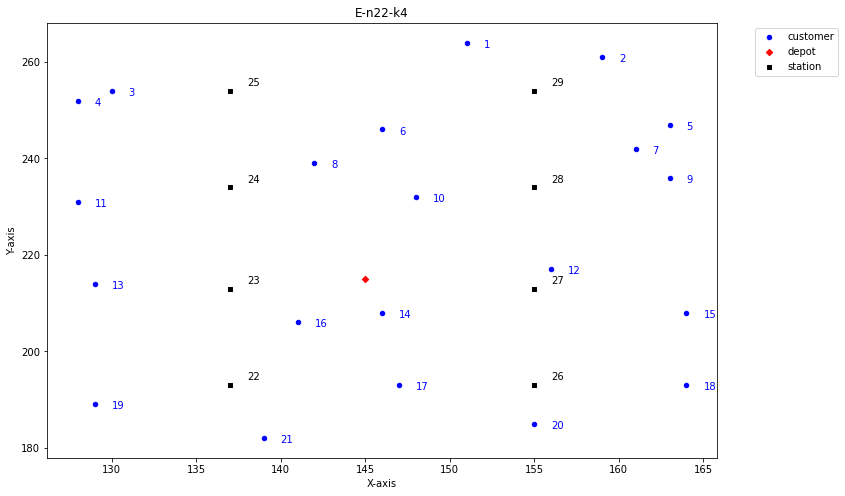

In [3]:
%run read_data.ipynb

In [4]:
BASE_DIR = os.path.abspath(os.path.dirname(os.path.dirname('.')))
data_dir = os.path.join(BASE_DIR, 'evrp-benchmark-set')
result_dir = os.path.join(BASE_DIR, 'results')

In [134]:
# instance.__dict__

## Utils

In [5]:
def is_capacity_feasible(individual, capacity, demands):
    """Check if a given individual is feasible with respect to vehicle capacity.
    
    Args:
        individual: A list of lists, where each sublist represents a vehicle and its assigned customers.
        capacity: The capacity of the vehicles.
        demands: The dictionary containing the demands of each customer.
        
    Returns:
        bool: True if the individual is feasible, False otherwise.
    """
    
    # Iterate through each route in the individual
    for route in individual:
        # Calculate the total demand of the customers in the route
        total_demand = sum(demands[f'{customer}'] for customer in route)
        
        # If the total demand exceeds the vehicle's capacity, the individual is not feasible
        if total_demand > capacity:
            return False
    
    # If none of the routes exceed the vehicle's capacity, the individual is feasible
    return True

def reconstruct_individual(flat_ind, route_lengths):
    '''Reconstruct the original format of an individual from a flattened version.
    
    Args:
        flat_ind: A flattened version of an individual, where all routes are combined into a single list.
        route_lengths: A list of integers representing the length of each route in the original individual format.

    Returns:
        A list of lists, where each sublist represents a vehicle and its assigned customers.
    '''
    individual = []
    start_idx = 0
    for length in route_lengths:
        individual.append(flat_ind[start_idx:start_idx + length])
        start_idx += length
    return individual


def deduplicate_population(population):
    """
    Remove duplicate individuals from a population.
    
    Args:
        population: A list of individuals.
        
    Returns:
        A deduplicated population as a list.
    """
    deduplicated_population = []

    for individual in population:
        if individual not in deduplicated_population:
            deduplicated_population.append(individual)

    return deduplicated_population

def find_nearest_station(node_no, distance_matrix, station_list):
    '''Find the nearest charging station of the given node
    
    Args:
        node: the index of the node
        distance_matrix: the distance matrix of nodes
        staion_list: the list of station nodes 
    
    Returns:
        the index of the station
    '''
    return int(min(station_list, key=lambda station_no: distance_matrix[int(node_no)][int(station_no)])) 

def plot_route(route, df, ax, route_color='green', linewidth=1):
    # Add the depot index (0) at the beginning and end of the route
    route_with_depot = [0] + route + [0]

    for i in range(len(route_with_depot) - 1):
        start_customer_idx = route_with_depot[i]
        end_customer_idx = route_with_depot[i + 1]

        x1, y1 = df['x_pos'].loc[start_customer_idx], df['y_pos'].loc[start_customer_idx]
        x2, y2 = df['x_pos'].loc[end_customer_idx], df['y_pos'].loc[end_customer_idx]

        ax.plot([x1, x2], [y1, y2], color=route_color, linewidth=linewidth)

def visualize_routes(routes, df, title='Route Plot'):
    colors = {'depot': 'red', 'customer': 'blue', 'station': 'black'}
    markers = {'depot': 'D', 'customer': 'o', 'station': 's'}

    fig, ax = plt.subplots(figsize=(12, 8))
    for label, group in df.groupby('label'):
        if label == 'depot':
            group.plot(kind='scatter', x='x_pos', y='y_pos', label=label, color=colors[label], marker=markers[label], ax=ax, s=30)
        elif label == 'customer':
            group.plot(kind='scatter', x='x_pos', y='y_pos', label=label, color=colors[label], marker=markers[label], ax=ax)
        else:  # For the 'station' label
            group.plot(kind='scatter', x='x_pos', y='y_pos', label=label, color=colors[label], marker=markers[label], ax=ax, s=30) 
            

        # Add node_no labels for customer nodes
        if label == 'customer':
            for index, row in group.iterrows():
                ax.text(row['x_pos'] + 1, row['y_pos'] - 1, str(row['node_no']), fontsize=10, color=colors[label])
        elif label == 'station':
            for index, row in group.iterrows():
                ax.text(row['x_pos'] + 1, row['y_pos'] + 1, str(row['node_no']), fontsize=10, color=colors[label])
    
    # Create a colormap and generate a list of colors for each route
    colormap = plt.cm.get_cmap('tab10', len(routes))
    colors = [mcolors.rgb2hex(colormap(i)[:3]) for i in range(len(routes))]

    for i, route in enumerate(routes):
        plot_route(route, df, ax, route_color=colors[i])
    
    
    ax.set_title(title)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

    # Move the legend and show the plot inside the loop
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

## GA Implementation
-----
### Individual (Chromosome) encoding
* `0 - 5 - 6 - 8 - 0 - 1 - 2 - 3 - 4 - 0 - 7 - 0`
* there are many methods to generate the individual, for example, Density-Based Clustering Algorithm to partition the set in advance

### Individual initialization

1. generate individual without capacity violation
    * evenly
    * randomly
    * approach proposed by David & Viktor (manuscript)
2. make the individual feasible w.r.t energy consumption, otherwise discard these infeasible individuals. 
we can use Relaxed ZGA repair procedure.



In [6]:
def generate_individual_evenly(num_vehicles, num_customers):
    """Generate an individual by distributing customers evenly across vehicles.
    
    Args:
        num_vehicles: The number of vehicles.
        num_customers: The number of customers.
        
    Returns:
        A list of lists, where each sublist represents a vehicle and its assigned customers.
    """

    # Create a list of customer numbers and shuffle it
    customers = list(range(1, num_customers + 1))

    # Initialize the individual
    individual = []

    random.shuffle(customers)
    individual = [customers[i::num_vehicles] for i in range(num_vehicles)]
    
    return individual


def generate_individual_randomly(num_vehicles, num_customers):
    """Generate an individual by randomly assigning customers to vehicles.
    
    Args:
        num_vehicles: The number of vehicles.
        num_customers: The number of customers.
        
    Returns:
        A list of lists, where each sublist represents a vehicle and its assigned customers.
    """
    
    # Initialize an empty individual with a list for each vehicle
    individual = [[] for _ in range(num_vehicles)]
    
    # Create a list of customers and shuffle it
    customers = list(range(1, num_customers + 1))
    random.shuffle(customers)
    
    for customer in customers:
        # Assign the customer to a random vehicle
        vehicle = random.randint(0, num_vehicles - 1)
        individual[vehicle].append(customer)
    
    return individual


In [7]:
num_vehicles =  instance.num_of_vehicles
num_customers = instance.dimension - 1
capacity = instance.capacity
demands = instance.demands


pop_size = 10000
pop_1 = []
pop_2 = []
for x in range(pop_size):
    ind1 = generate_individual_evenly(num_vehicles, num_customers)
    pop_1.append(ind1)
    ind2 = generate_individual_randomly(num_vehicles, num_customers)
    pop_2.append(ind2)

num_cap_fea_1 = 0
num_cap_fea_2 = 0

for ind in pop_1:
    cap_fea = is_capacity_feasible(ind, capacity, demands)
#     print(f'{ind}  {cap_fea}')
    if cap_fea:
        num_cap_fea_1 += 1
    
for ind in pop_2:
    cap_fea = is_capacity_feasible(ind, capacity, demands)
#     print(f'{ind}  {cap_fea}')
    if cap_fea:
        num_cap_fea_2 += 1
        
print('-------------', end="\n\n")
print('The number of capacity feasible individual for population 1: ', num_cap_fea_1/pop_size)
print('The number of capacity feasible individual for population 2: ', num_cap_fea_2/pop_size)

-------------

The number of capacity feasible individual for population 1:  0.0235
The number of capacity feasible individual for population 2:  0.0033


## Operators (Moves)

* Crossover - partially matched crossover (PMX)

* muatation

* 2-opt-route  <br>
  For each plain route, make the 2-opt operator to ensure that there are no intersecting paths in the route, i.e., find the route has the shortest the total length.
  
* a

In [10]:
# crossover
def cx_partially_matched(ind1, ind2):
    """Partially Matched Crossover (PMX)
    
    Args:
        ind1: The first individual participating in the crossover.
        ind2: The second individual participating in the crossover.
        
    Returns:
        A tuple of two individuals.
    """
    
    route_lengths_1 = [len(route) for route in ind1]
    route_lengths_2 = [len(route) for route in ind2]
    flat_ind1 = [node - 1 for route in ind1 for node in route]
    flat_ind2 = [node - 1 for route in ind2 for node in route]
    
    size = min(len(flat_ind1), len(flat_ind2))
    pos1, pos2 = [0] * size, [0] * size

    # Initialize the position of each index in the individuals
    for i in range(size):
        pos1[flat_ind1[i]] = i
        pos2[flat_ind2[i]] = i
    
    # Choose crossover points
    cxpoint1 = random.randint(0, size)
    cxpoint2 = random.randint(0, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else:  # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    # Apply crossover between cx points
    for i in range(cxpoint1, cxpoint2):
        # Keep track of the selected values
        temp1 = flat_ind1[i]
        temp2 = flat_ind2[i]
        # Swap the matched value
        flat_ind1[i], flat_ind1[pos1[temp2]] = temp2, temp1
        flat_ind2[i], flat_ind2[pos2[temp1]] = temp1, temp2
        # Position bookkeeping
        pos1[temp1], pos1[temp2] = pos1[temp2], pos1[temp1]
        pos2[temp1], pos2[temp2] = pos2[temp2], pos2[temp1]

    # Increment node values back to original range
    flat_ind1 = [node + 1 for node in flat_ind1]
    flat_ind2 = [node + 1 for node in flat_ind2]
    

    ind1_reconstructed = reconstruct_individual(flat_ind1, route_lengths_1)
    ind2_reconstructed = reconstruct_individual(flat_ind2, route_lengths_2)
    
    return ind1_reconstructed, ind2_reconstructed


In [12]:
ind1 = [[11, 15, 17, 6], [1, 20, 12, 21, 5, 4], [3, 14, 7, 13, 10, 19, 2, 9], [18, 8, 16]] 
ind2 = [[15, 13, 17, 3, 18, 21, 9], [ 6, 20, 14], [19, 8, 11, 1, 2, 5, 16, 10, 12], [7, 4]]
a, b = cx_partially_matched(ind1, ind2)
print(a)
print(b)

[[7, 15, 17, 21], [13, 5, 9, 6, 20, 14], [19, 8, 11, 1, 2, 3, 10, 12], [18, 4, 16]]
[[15, 1, 17, 19, 18, 6, 12], [21, 5, 8], [3, 4, 7, 13, 10, 20, 16, 2, 9], [11, 14]]


* __mutation__ 

In [13]:
# mutation
def mut_shuffle_indexes(individual, indpb):
    """Shuffle the attributes of the input individual and return the mutant.
    The *indpb* argument is the probability of each attribute to be moved. 

    Args:
        individual: Individual to be mutated.
        indpb: Independent probability for each attribute to be exchanged to
                  another position.
        
    Returns:
        A tuple of one individual.
    """
    route_lengths = [len(route) for route in individual]
    flat_ind = [node for route in individual for node in route]
    
    size = len(flat_ind)
    for i in range(size):
        if random.random() < indpb:
            swap_indx = random.randint(0, size - 2)
            if swap_indx >= i:
                swap_indx += 1
            flat_ind[i], flat_ind[swap_indx] = flat_ind[swap_indx], flat_ind[i]

    individual = reconstruct_individual(flat_ind, route_lengths)
    return individual,

In [14]:
ind1 = [[11, 15, 17, 6, 1, 20], [12, 21, 5, 4], [3, 14, 7, 13, 10, 19, 2, 9], [18, 8, 16]] 
_ind, = mut_shuffle_indexes(ind1, 0.2)
print(_ind)

[[21, 8, 17, 6, 19, 20], [5, 3, 12, 4], [11, 14, 7, 16, 10, 2, 1, 9], [18, 15, 13]]


In [16]:

candidates = []

num_vehicles =  instance.num_of_vehicles
num_customers = instance.dimension - 1
capacity = instance.capacity
demands = instance.demands

pop_size = 10000

pop = []
for x in range(pop_size):
    ind = generate_individual_randomly(num_vehicles, num_customers)
    pop.append(ind)

offspring = []
for ind1, ind2 in zip(pop[::2], pop[1::2]):
    child1, child2 = cx_partially_matched(ind1, ind2)
    offspring.append(child1)
    offspring.append(child2)

num_cap_fea = 0
for ind in pop:
    cap_fea = is_capacity_feasible(ind, capacity, demands)
    if cap_fea:
        num_cap_fea += 1
        candidates.append(ind)
print('------------------ crossover -------------------')

print('The probability of capacity feasible individual for population: ', num_cap_fea/pop_size)


num_cap_fea = 0
for ind in offspring:
    cap_fea = is_capacity_feasible(ind, capacity, demands)
    if cap_fea:
        num_cap_fea += 1
        candidates.append(ind)

print('The probability of capacity feasible individual for offspring: ', num_cap_fea/pop_size)

print()
print('------------------ muatation -------------------')
mut_prob = 0.5
offspring_after_muatation = []
for ind in offspring:
    if random.random() < mut_prob:
        mutant, = mut_shuffle_indexes(ind, 0.2)
        offspring_after_muatation.append(mutant)

num_cap_fea = 0
for ind in offspring_after_muatation:
    cap_fea = is_capacity_feasible(ind, capacity, demands)
    if cap_fea:
        num_cap_fea += 1
        candidates.append(ind)

print('The probability of capacity feasible individual for offspring_after_muatation: ', num_cap_fea/pop_size)

print()
print('------------------ CANDIDATES -------------------')

CANDIDATES = deduplicate_population(candidates)


# for individual in CANDIDATES:
#     print(individual)
    
print(len(CANDIDATES))

------------------ crossover -------------------
The probability of capacity feasible individual for population:  0.005
The probability of capacity feasible individual for offspring:  0.0038

------------------ muatation -------------------
The probability of capacity feasible individual for offspring_after_muatation:  0.0015

------------------ CANDIDATES -------------------
103


* __2-opt-route__

> 1. Croes GA. A method for solving traveling-salesman problems. Operations research. 1958 Dec;6(6):791-812.
> 2. Flood MM. The traveling-salesman problem. Operations research. 1956 Feb;4(1):61-75.

In [17]:
def two_opt(route, distance_matrix):
    """
    Perform 2-opt local search on a given route to optimize it.
    
    Args:
        route: A list of integers representing the customers in the route.
        distance_matrix: A 2D list or numpy array containing the distances between nodes.
    
    Returns:
        A list of integers representing the optimized route.
    """
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route) - 1):
                
                # Calculate the cost difference between the old route and the new route obtained by swapping edges
                old_cost = distance_matrix[route[i - 1]][route[i]] + distance_matrix[route[j]][route[j + 1]]
                new_cost = distance_matrix[route[i - 1]][route[j]] + distance_matrix[route[i]][route[j + 1]]
                if new_cost < old_cost:
                    route[i:j + 1] = reversed(route[i:j + 1])
                    improved = True
    return route

[[11, 7, 3, 20, 6], [10, 13, 1, 21, 4, 18], [5, 8, 19, 17, 14], [16, 2, 12, 9, 15]]


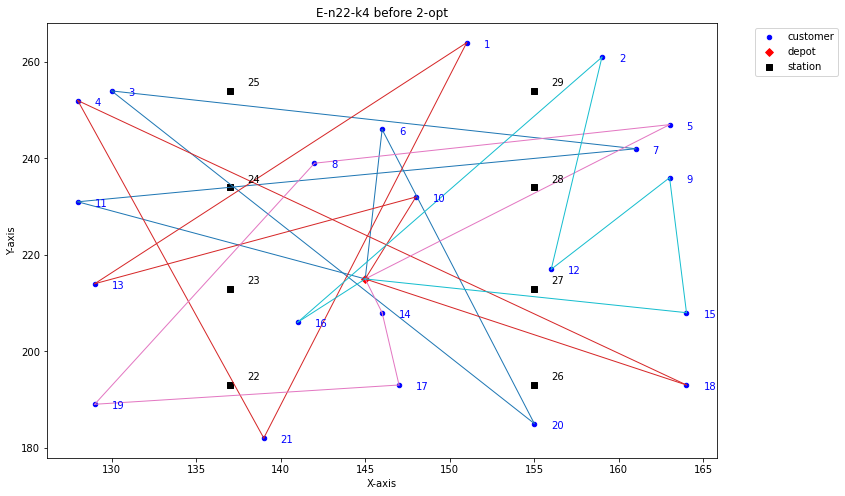

[[20, 7, 6, 3, 11], [10, 1, 4, 13, 21, 18], [5, 8, 19, 17, 14], [16, 15, 9, 2, 12]]


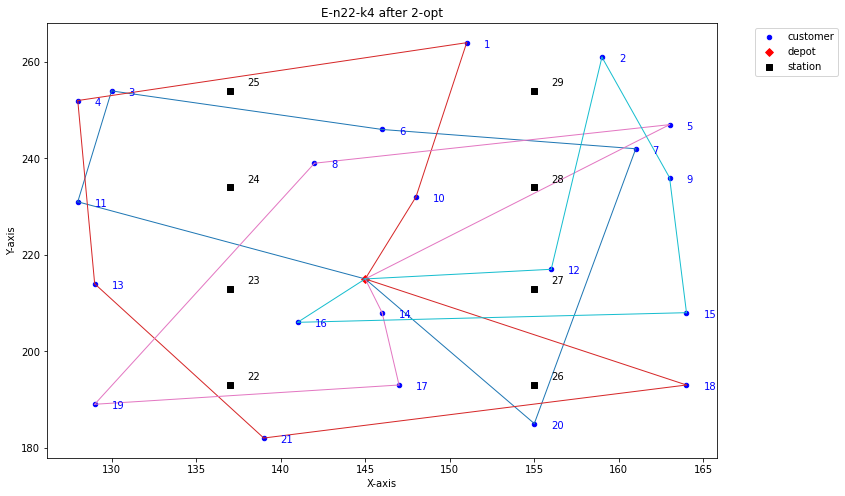

In [18]:
distance_matrix = instance.distance_matrix
df = create_dataframe(instance)

original_individual = CANDIDATES[1].copy()
print(original_individual)
visualize_routes(original_individual, df, instance.name + ' before 2-opt')

optimized_individual = []
for route in original_individual:
    extended_route = [0] + route + [0]
    improved_route = two_opt(extended_route, distance_matrix)
    optimized_individual.append(improved_route[1:-1])

print(optimized_individual)
visualize_routes(optimized_individual, df, instance.name + ' after 2-opt')


* __repair__

> Relaxed ZGA repair procedure

In [19]:
def simple_repair(initial_route, battery_capacity, energy_consumption, distance_matrix, station_list):
    """
    Repair the given route by ensuring the vehicle has enough energy to reach a charging station from each node.

    Args:
        initial_route (list): The initial route that needs to be repaired.
        battery_capacity (float): The capacity of the vehicle's battery.
        energy_consumption (float): The energy consumption per unit distance.
        distance_matrix (list of lists): A matrix representing the distances between each pair of nodes.
        station_list (list): A list of charging station indices.
    
    Returns:
        list: The repaired route, which ensures that the vehicle has enough energy to reach a charging station from each node.
    """
    route = initial_route.copy()

    repaired_route = [route.pop(0)]
    current_node = repaired_route[-1]
    next_node = route[0]

    # Calculate the remaining energy after departing from the first node
    energy_left = battery_capacity - energy_consumption * distance_matrix[0][current_node]
    
    while route:
        # Update the energy left after moving to the next node
        updated_energy_left = energy_left - energy_consumption * distance_matrix[current_node][next_node]
        nearest_station_to_next = find_nearest_station(next_node, distance_matrix, station_list)

        # Check if there is enough energy left to reach the nearest station from the next node
        if updated_energy_left >= energy_consumption * distance_matrix[next_node][nearest_station_to_next]:
            repaired_route.append(next_node)
            route.pop(0)
            next_node = route[0] if len(route) > 0 else 0
            current_node = repaired_route[-1]
            energy_left = updated_energy_left
        else:
            # Find stations reachable from the current node
            reachable_stations_from_current = [int(station) for station in station_list if energy_left >= energy_consumption * distance_matrix[current_node][int(station)]]
            nearest_station_to_next = find_nearest_station(next_node, distance_matrix, reachable_stations_from_current)

            repaired_route.append(nearest_station_to_next)
            energy_left = battery_capacity
            current_node = repaired_route[-1]

    # we have to check whether the energy left can support the vehicle to return back to the depot
    if energy_left < energy_consumption * distance_matrix[current_node][0]:
        nearest_station_to_current = find_nearest_station(current_node, distance_matrix, station_list)
        repaired_route.append(nearest_station_to_current)
    
    return repaired_route


[[20, 7, 6, 3, 11], [10, 1, 4, 13, 21, 18], [5, 8, 19, 17, 14], [16, 15, 9, 2, 12]]


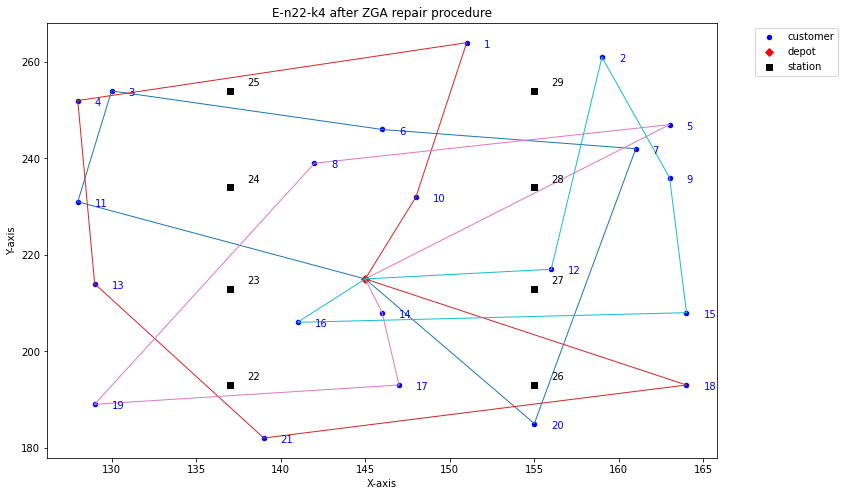

[[20, 27, 7, 6, 3, 25, 11], [10, 1, 25, 4, 13, 22, 21, 18], [5, 8, 24, 19, 17, 22, 14], [16, 15, 9, 28, 2, 12, 27]]


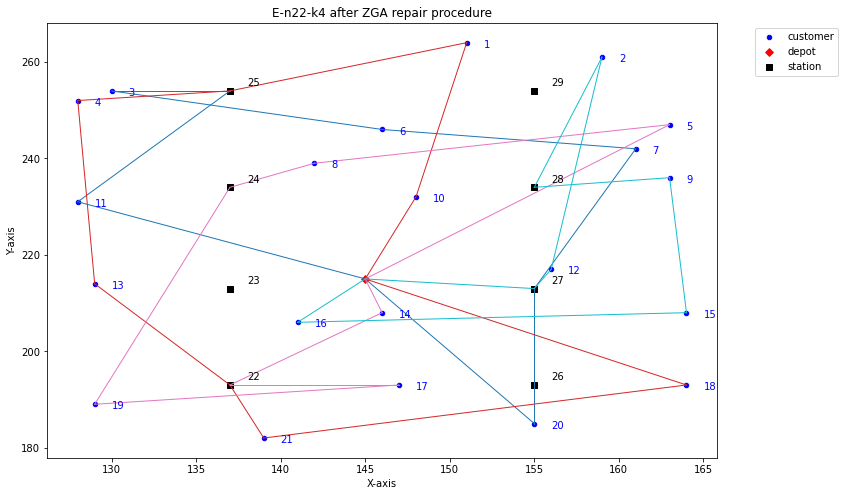

In [20]:
battery_capacity = instance.battery_capacity
energy_consumption = instance.energy_consumption
distance_matrix = instance.distance_matrix
station_list = instance.station_list

original_individual = optimized_individual
repaired_individual = []

for route in original_individual:
    repaired_route = simple_repair(route, battery_capacity, energy_consumption, distance_matrix, station_list)
    repaired_individual.append(repaired_route)

print(original_individual)

visualize_routes(original_individual, df, instance.name + ' after ZGA repair procedure')

print(repaired_individual)
visualize_routes(repaired_individual, df, instance.name + ' after ZGA repair procedure')


In [21]:
def validate_generated_individual_details(route, instance, is_detailed=True):
    '''Validate the results of the function individual_2_route, check the feasibility of them.
    The function will do two tasks: 1. print the details of the route; 2. if some unexcepted info appears, then Note it! 
    
    Args:
        route: the result from the function `individual_2_route`
        instance: the benchmark instance got from the original data
        is_detailed: whether print the detailed info
    '''
    MAX_CAPACITY = instance.capacity
    BATTERY_CAPACITY = instance.battery_capacity
    ENERGY_CONSUMPTION = instance.energy_consumption
    NUM_OF_VEHICLES = instance.num_of_vehicles
    STATION_LIST = instance.station_list
    DISTANCE_MATRIX = instance.distance_matrix
    DEMANDS = instance.demands
    
    delim = '-'
    
    for idx, sub_route in enumerate(route):
        
        sub_route = [0] + sub_route + [0]
        
        
        detailed_sub_route = []
        capacity_left_list = []
        energy_left_list   = []
        
        capacity_left = MAX_CAPACITY
        energy_left   = BATTERY_CAPACITY
        prev_node = 0
        
        for node in sub_route:
            if str(node) in STATION_LIST:
                energy_left = BATTERY_CAPACITY
                prev_node = node
                
                detailed_sub_route.append('{}({}, {:.2f})'.format(prev_node, capacity_left, energy_left))
                
                if capacity_left < 0 or energy_left < 0:
                    print('******NOTE*******  ', capacity_left, energy_left)
            else:
                capacity_left -= DEMANDS[f'{node}']
                energy_left -= ENERGY_CONSUMPTION * DISTANCE_MATRIX[prev_node][node]
                prev_node = node
                    
                detailed_sub_route.append('{}({}, {:.2f})'.format(prev_node, capacity_left, energy_left))
                
                if capacity_left < 0 or energy_left < 0:
                    print('******NOTE*******  ', capacity_left, energy_left)
                    
        if is_detailed == True:
            print(delim.join(map(str, detailed_sub_route)), end='\n\n')


In [22]:
print(repaired_individual)
print()
validate_generated_individual_details(repaired_individual, instance)

[[20, 27, 7, 6, 3, 25, 11], [10, 1, 25, 4, 13, 22, 21, 18], [5, 8, 24, 19, 17, 22, 14], [16, 15, 9, 28, 2, 12, 27]]

0(6000, 94.00)-20(4200, 56.05)-27(4200, 94.00)-7(3400, 58.46)-6(3000, 39.83)-3(2200, 18.37)-25(2200, 94.00)-11(1000, 64.36)-0(1000, 36.35)

0(6000, 94.00)-10(5400, 73.28)-1(4300, 34.72)-25(4300, 94.00)-4(2900, 82.94)-13(1600, 37.32)-22(1600, 94.00)-21(900, 80.58)-18(0, 47.81)-0(0, 12.93)

0(6000, 94.00)-5(3900, 49.94)-8(3800, 22.98)-24(3800, 94.00)-19(1300, 39.15)-17(300, 17.03)-22(300, 94.00)-14(0, 73.01)-0(0, 64.52)

0(6000, 94.00)-16(3900, 82.18)-15(3000, 54.48)-9(2500, 20.86)-28(2500, 94.00)-2(1800, 61.25)-12(500, 8.32)-27(500, 94.00)-0(500, 81.76)

